In [13]:
## Trim down imports to only neccesary 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from transformers import AutoFeatureExtractor, ViTForImageClassification, ViTModel, ViTImageProcessor 
import torch
from torchvision.transforms import v2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('default')
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.utils.data import Subset
from collections import namedtuple
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
from torchvision.io import read_image

import datasets_1 as datasets

import os
import datetime
import re




import simple_datasets as sd
import importlib
importlib.reload(sd)


<module 'simple_datasets' from '/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/simple_datasets.py'>

In [2]:
## Pretrained model

class CustomViTEmbeddingModel(torch.nn.Module):
    def __init__(self, original_model):
        super(CustomViTEmbeddingModel, self).__init__()
        
        # Extract the necessary layers from the original model
        self.embeddings = original_model.vit.embeddings  #.patch_embeddings
        self.encoder_layer_0 = original_model.vit.encoder.layer[0]
        self.encoder_layer_1 = original_model.vit.encoder.layer[1]
        
        # Assume a square grid of patches to reshape the sequence of patches back into a 2D grid
            ## image: 224x224 ; patch size: 16x16 --> 14x14 
        self.num_patches_side = 14

    def forward(self, x):
        # Apply the embeddings layer
        x = self.embeddings(x)
        
        # Pass the result through the first and second encoder layers
        x = self.encoder_layer_0(x)[0]  # [0] to get the hidden states
        x = self.encoder_layer_1(x)[0]  # [0] to get the hidden states
        
        # x is now the sequence of embeddings for the patches
            # The output x will be a sequence of embeddings, one for each patch of the input images.
            # If you're looking for a single vector representation per image, typically the class token embedding (the first token) is used. 
            # If the model doesn't use a class token, you might need to apply a different pooling strategy over the patch embeddings.
        
        ## Updating to reshape
        
        # Before reshaping, x is in shape [batch_size, num_patches+1, embedding_dim]
        # We discard the first token which is used for classification in the original ViT model
        x = x[:, 1:, :]  # Now in shape [batch_size, num_patches, embedding_dim]
        
        # Reshape to [batch_size, num_patches_side, num_patches_side, embedding_dim]
        x = x.reshape(-1, self.num_patches_side, self.num_patches_side, x.size(-1))

        # Permute to get [batch_size, embedding_dim, num_patches_side, num_patches_side]
        # This is a pseudo-spatial 2D grid, where embedding_dim becomes the channel dimension
        x = x.permute(0, 3, 1, 2)
        
        return x



In [24]:
## Adding in CNN component


## CNN for regression
class RegressionCNN(nn.Module):
    ## Maybe try messing w/ kernel_size, padding and stride?
    def __init__(self, embedding_dim):
        super(RegressionCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=embedding_dim, out_channels=256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.sig1 = nn.Sigmoid()

        # Second convolutional layer
            ## Same amount? Dropout should help it to learn other things
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.sig2 = nn.Sigmoid()
        
        # Third convolutional layer -- new
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.sig3 = nn.Sigmoid()
        
        
        self.dropout = nn.Dropout(p=0.1)

        # Adaptive pooling layer to pool down to 1x1
        self.adapt_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final fully connected layer for regressin
        self.fc = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        ## No more batch normalization
        
        
        ## Check to make sure BN is needed
        if x.shape[3] < 2:
            
            x = self.sig1(self.conv1(x))
            
            x = self.sig2(self.conv2(x))
            
            x = self.sig3(self.conv3(x))
                
        else:
        # Apply first convolution, batch norm, and activation
            x = self.sig1(self.bn1(self.conv1(x)))
            # Apply second convolution, batch norm, and activation

            x = self.sig2(self.bn2(self.conv2(x)))
            # Apply third convolution, batch norm, and activation -- new
            x = self.sig3(self.bn3(self.conv3(x)))
       
        
        # Apply dropout
        x = self.dropout(x)
        # Pool the output from the convolutional layers
        x = self.adapt_pool(x)
        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, start_dim=1)
        # Fully connected layer for regression
        x = self.fc(x)
        return x

In [20]:
def evaluate_model(model, custom_model, loader = None, test_img_data = None, test_depth_data = None, return_extra=False,):
    model.eval()
    predictions, actuals, depths,sources, indices = [], [], [], [], []
    ## Assume we have a dataset with all test sources, test depths and target values
    ## Assume we have test dataframe with all images, depths, sources, and labels
    
    with torch.no_grad():
        
        if loader:
            
            for batch in loader:
                batch_indices, images, labels, batch_depths, batch_source = batch
                embeddings = custom_model(images)
                preds = model(embeddings)
                predictions.extend(preds.view(-1))
                actuals.extend(labels)
                if return_extra:
                    depths.extend(batch_depths)
                    sources.extend(batch_source)
                    indices.extend(batch_indices)
                    
        elif test_img_data is not None and not test_img_data.empty and test_depth_data is not None and not test_depth_data.empty:
            ## For example in test_dataset:
            ## Get all examples in test dataframe where depth +/- 2
            ## predict and store in return df: source, depth, prediction, actual, # of images
            ## Add on each prediction and then average by number of samples
            ## append final result to return df
            # Initialize an empty list to store intermediate data
            aggregated_data = []

            feature_extractor = ViTImageProcessor.from_pretrained('facebook/deit-tiny-patch16-224')
            # Transform images
            test_img_data['image_tensor'] = test_img_data['chunk'].apply(lambda x: sd.transform_image(x, feature_extractor))

            for i, entry in test_depth_data.iterrows():
                sample_img_data = test_img_data[(test_img_data.depth >= (entry.depth - 2.5)) & 
                                                (test_img_data.depth <= (entry.depth + 2.5)) & 
                                                (test_img_data.source == entry.source)]

                # Temporary list to hold predictions for averaging
                temp_predictions = []
                
                if sample_img_data.empty:
                    print(entry.depth,entry.source)
                    return "ERROR"

                for j, example in sample_img_data.iterrows():
                    embedding = custom_model(torch.unsqueeze(example['image_tensor'], 0))  # Add batch dimension
                    pred = model(embedding)
                    temp_predictions.append(pred.item())

                # If there are predictions, calculate the average --> Should never be "if" else we have a problem
                avg_pred = sum(temp_predictions) / len(temp_predictions)
                aggregated_data.append({'depth': entry.depth, 
                                        'actuals': entry.label,
                                        'predictions': avg_pred, 
                                        'source': entry.source})

            # Convert aggregated data into a DataFrame
            return_df = pd.DataFrame(aggregated_data)
            
            depths = return_df['depth'].tolist()
            actuals = return_df['actuals'].tolist()
            predictions = return_df['predictions'].tolist()
            sources = return_df['source'].tolist()
            
            
            if return_extra:
                ## No indices
                return None, sources, depths, actuals, predictions
            else:
                return actuals, predictions
            
        else:
            print("problem")
            return "error"

            
    if return_extra:
        return indices, sources, depths, actuals, predictions
    else:
        return actuals, predictions



In [5]:
def plot_results(train_depths, train_actuals, train_predictions, train_sources,
                 test_depths, test_actuals, test_predictions, test_sources, test_indices,
                 title, save_path, rmse_save_path):
    plt.figure(figsize=(10, 9))
    
    # Convert to numpy arrays
    test_indices = np.array(test_indices)
    test_depths = np.array(test_depths)
    test_actuals = np.array(test_actuals)
    test_sources = np.array(test_sources)
    test_predictions = np.array(test_predictions)
    train_depths = np.array(train_depths)
    train_actuals = np.array(train_actuals)
    train_sources = np.array(train_sources)
    train_predictions = np.array(train_predictions)
    
    # After computing RMSEs
    lvid_test_mask = test_sources == "LVID"
    svid_test_mask = test_sources == "SVID"
    

    # Create a grid with 2 rows and 1 column, 
    # the first row is twice the height of the second row
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

    # Main plot for actual values
    ax1 = plt.subplot(gs[0])

    for lake in ['LVID', 'SVID']:
        # Filter train and test data
        train_mask = (train_sources == lake)
        test_mask = (test_sources == lake)
        
        #print(f"{lake} - Train mask sum: {np.sum(train_mask)}, Test mask sum: {np.sum(test_mask)}")

        # Check and concatenate
        if np.any(train_mask) or np.any(test_mask):
            all_depths = np.concatenate([train_depths[train_mask], test_depths[test_mask]])
            all_actuals = np.concatenate([train_actuals[train_mask], test_actuals[test_mask]])
            #print("Check\n", all_depths, "\n", all_actuals)
            sorted_indices = np.argsort(all_depths)
            plt.plot(all_depths[sorted_indices], all_actuals[sorted_indices], label=f'{lake} Actual', linestyle='-', marker='o')

    ax1.set_xlabel('Sediment Depth')
    ax1.set_ylabel('Target Variable')
    ax1.set_title(title)
    ax1.legend()
    ax1.grid(True)

    # Subplot for residuals
    ax2 = plt.subplot(gs[1])

    for lake in ['LVID', 'SVID']:
        # Filter train and test data for residuals
        train_mask = (train_sources == lake)
        test_mask = (test_sources == lake)

        # Check and plot residuals
        if np.any(train_mask):
            train_depths_lake = train_depths[train_mask]
            train_residuals = abs(train_actuals[train_mask] - train_predictions[train_mask])
            sorted_indices = np.argsort(train_depths_lake)
            plt.plot(train_depths_lake[sorted_indices], train_residuals[sorted_indices], label=f'{lake} Train Residual', linestyle='-', marker='x')

        if np.any(test_mask):
            test_depths_lake = test_depths[test_mask]
            test_residuals = abs(test_actuals[test_mask] - test_predictions[test_mask])
            sorted_indices = np.argsort(test_depths_lake)
            plt.plot(test_depths_lake[sorted_indices], test_residuals[sorted_indices], label=f'{lake} Test Residual', linestyle='--', marker='o')

    ax2.set_xlabel('Sediment Depth')
    ax2.set_ylabel('Residuals')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
    

def old_plot_results(train_depths, train_actuals, train_predictions, train_sources, test_depths, test_actuals, test_predictions, test_sources, title, save_path):
    
    plt.figure(figsize=(10, 6))

    # Convert sources to numpy arrays if they are not already
    train_depths = np.array(train_depths)
    train_actuals = np.array(train_actuals)
    train_sources = np.array(train_sources)
    train_predictions = np.array(train_predictions)
    test_depths = np.array(test_depths)
    test_actuals = np.array(test_actuals)
    test_predictions = np.array(test_predictions)
    test_sources = np.array(test_sources)

    check = 0
    for lake in ['LVID', 'SVID']:
        # Filter and check train data
        lake_train_mask = train_sources == lake
        if np.any(lake_train_mask):
            lake_train_depths = train_depths[lake_train_mask]
            lake_train_actuals = train_actuals[lake_train_mask]
            sorted_train_indices = np.argsort(lake_train_depths)
            plt.plot(lake_train_depths[sorted_train_indices], lake_train_actuals[sorted_train_indices], label=f'{lake} Train', linestyle='-', marker='o')
            check += 1

        # Filter and check test data
        lake_test_mask = test_sources == lake
        if np.any(lake_test_mask):
            lake_test_depths = test_depths[lake_test_mask]
            lake_test_actuals = test_actuals[lake_test_mask]
            lake_test_predictions = test_predictions[lake_test_mask]
            sorted_test_indices = np.argsort(lake_test_depths)
            plt.plot(lake_test_depths[sorted_test_indices], lake_test_actuals[sorted_test_indices], label=f'{lake} Test Actual', linestyle='-', marker='o')
            plt.plot(lake_test_depths[sorted_test_indices], lake_test_predictions[sorted_test_indices], label=f'{lake} Test Predicted', linestyle='--', marker='x')
            check += 1
            
    if check == 0:
        return "No data to plot!"
    
    plt.xlabel('Sediment Depth')
    plt.ylabel('Target Variable')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()    
    

In [6]:
# Updated function
def run_experiment(train, test, target, cnn_model, custom_model, sediment_width = 5, num_epochs=100, lr=0.001):
    # Load data from CSV
    if train.upper() != "BOTH":
        train_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/MA_chunk_data/{train.upper()}/{sediment_width}cm/data/{target.lower()}_dataset.csv"
        train_loader = sd.create_MA_loader(train_path,
                        set = "Train")
    elif train.upper() == "BOTH":
        train_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/MA_chunk_data/LVID/{sediment_width}cm/data/{target.lower()}_dataset.csv"
        second_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/MA_chunk_data/SVID/{sediment_width}cm/data/{target.lower()}_dataset.csv"
        train_loader = sd.create_MA_loader(train_path,
                                        set = "Train",
                                        second_csv = second_path)
    if test.upper() != "BOTH":
        test_img_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/MA_chunk_data/{test.upper()}/{sediment_width}cm/data/{target.lower()}_dataset.csv"
        test_depth_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/MA_chunk_data/{test.upper()}/{sediment_width}cm/data/{target.lower()}_test_depth_dataset.csv"
        
        test_img_data = pd.read_csv(test_img_path)
        test_depth_data = pd.read_csv(test_depth_path)
        
    elif test.upper() == "BOTH":
        # Define the paths
        lvid_img_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/MA_chunk_data/LVID/{sediment_width}cm/data/{target.lower()}_dataset.csv"
        lvid_depth_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/MA_chunk_data/LVID/{sediment_width}cm/data/{target.lower()}_test_depth_dataset.csv"
        svid_img_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/MA_chunk_data/SVID/{sediment_width}cm/data/{target.lower()}_dataset.csv"
        svid_depth_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/MA_chunk_data/SVID/{sediment_width}cm/data/{target.lower()}_test_depth_dataset.csv"

        # Load the dataframes
        lvid_img_df = pd.read_csv(lvid_img_path)
        lvid_depth_df = pd.read_csv(lvid_depth_path)
        svid_img_df = pd.read_csv(svid_img_path)
        svid_depth_df = pd.read_csv(svid_depth_path)

        # Combine the image dataframes
        test_img_data = pd.concat([lvid_img_df, svid_img_df], ignore_index=True)

        # Combine the depth dataframes
        test_depth_data = pd.concat([lvid_depth_df, svid_depth_df], ignore_index=True)
        
        
        
    # Initialize optimizer and loss function
    optimizer = optim.Adam(cnn_model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    # Training loop
    for epoch in range(num_epochs):
        # Training steps...
        cnn_model.train()
        train_loss = 0
        for batch in train_loader:
            
            optimizer.zero_grad()
            images, labels = batch[1], batch[2]
            embeddings = custom_model(images)
            
            predictions = cnn_model(embeddings)
            predictions = predictions.squeeze() # used to be squeeze(-1)
            
            loss = loss_function(predictions, labels) # used to be labels.float()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

    # Evaluate on test data
    train_indices, train_sources, train_depths, train_actuals, train_predictions = evaluate_model(cnn_model,  custom_model, loader = train_loader,return_extra = True)
    test_indices, test_sources, test_depths, test_actuals, test_predictions = evaluate_model(cnn_model, custom_model, test_img_data = test_img_data, test_depth_data = test_depth_data, return_extra = True)

    return train_indices, train_depths, train_actuals, train_sources, train_predictions, test_indices, test_depths, test_actuals, test_predictions, test_sources

In [ ]:
# Load the pre-trained ViT model
pretrained_vit = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')

## Freeze params
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Create model w first three layers and create embedding
custom_model = CustomViTEmbeddingModel(pretrained_vit)

cnn_model = RegressionCNN(embedding_dim=192)
print(f"Running experiment for Target: %TOC, Train: both, Test: both")
scaler = None
        
train_depths, train_actuals, train_sources, train_predictions, test_depths, test_actuals, test_predictions, test_sources = run_experiment("n", cnn_model, custom_model, scaler, num_epochs=100, lr=0.001)



In [ ]:
old_plot_results(train_depths, train_actuals, train_predictions, train_sources, test_depths, test_actuals, test_predictions, test_sources, "title", "save_path")



Running experiment for Target: MBT, Train: lvid, Test: lvid


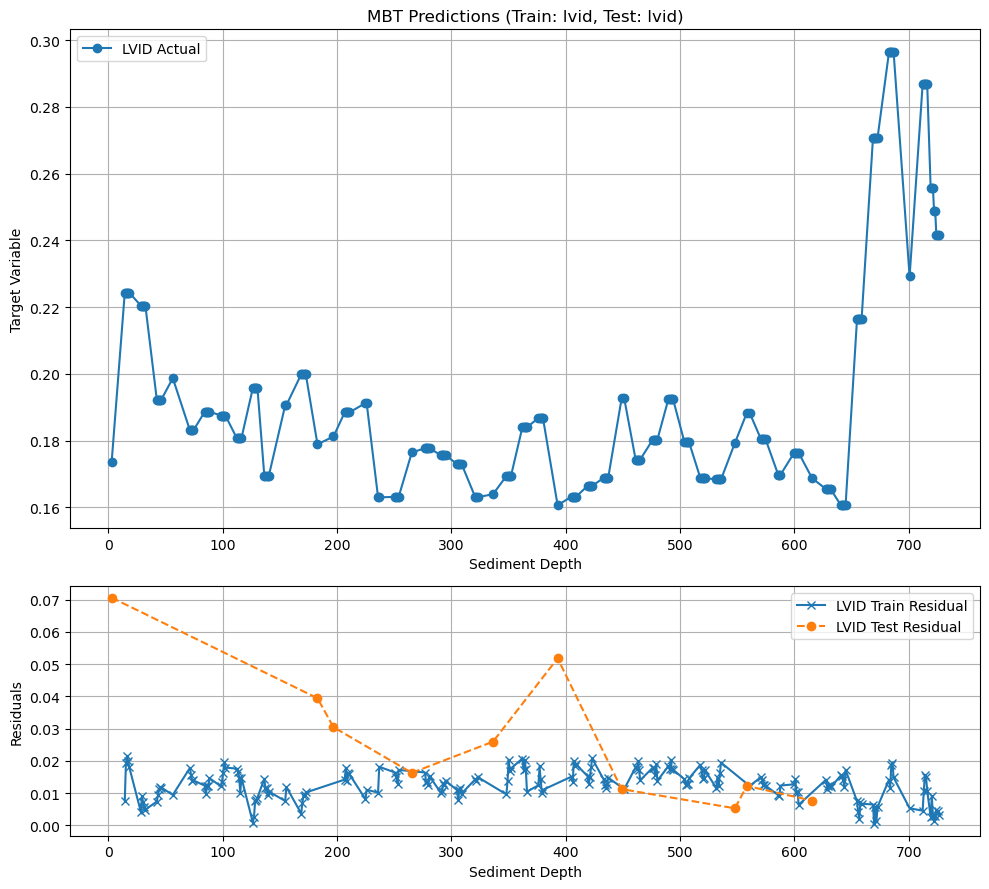

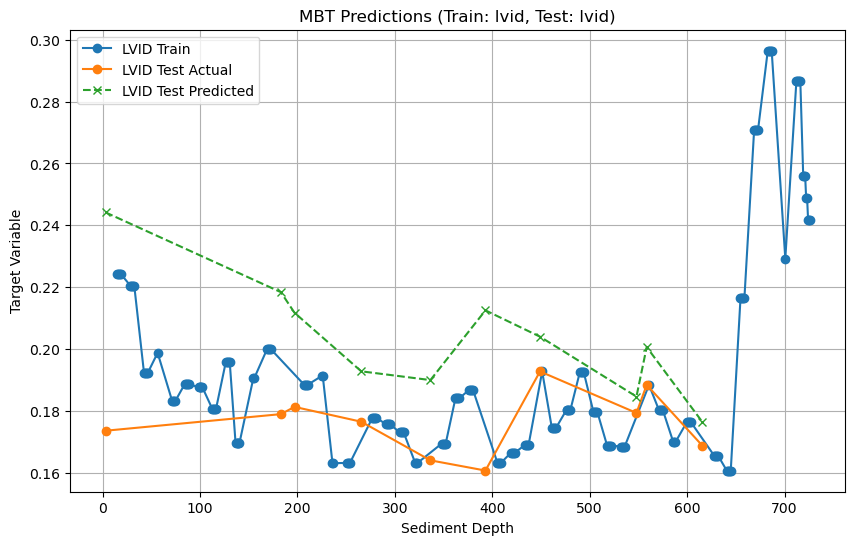

Running experiment for Target: MBT, Train: lvid, Test: svid


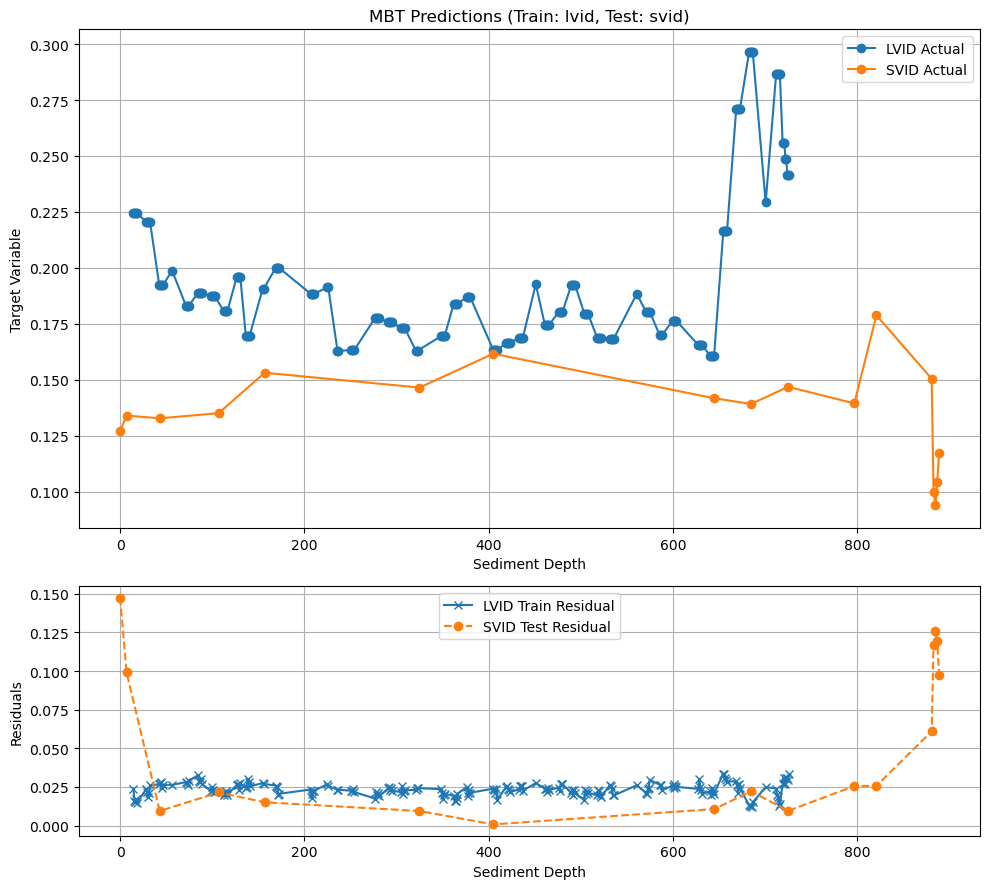

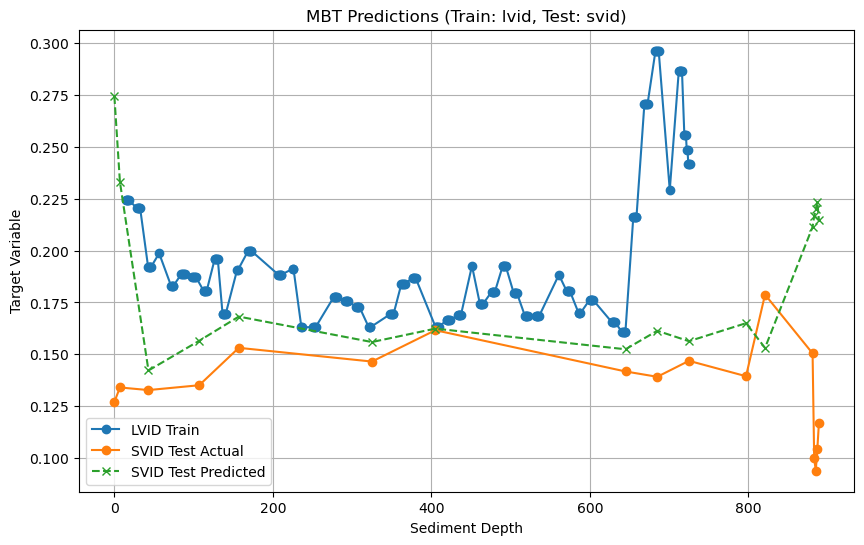

Running experiment for Target: MBT, Train: lvid, Test: both


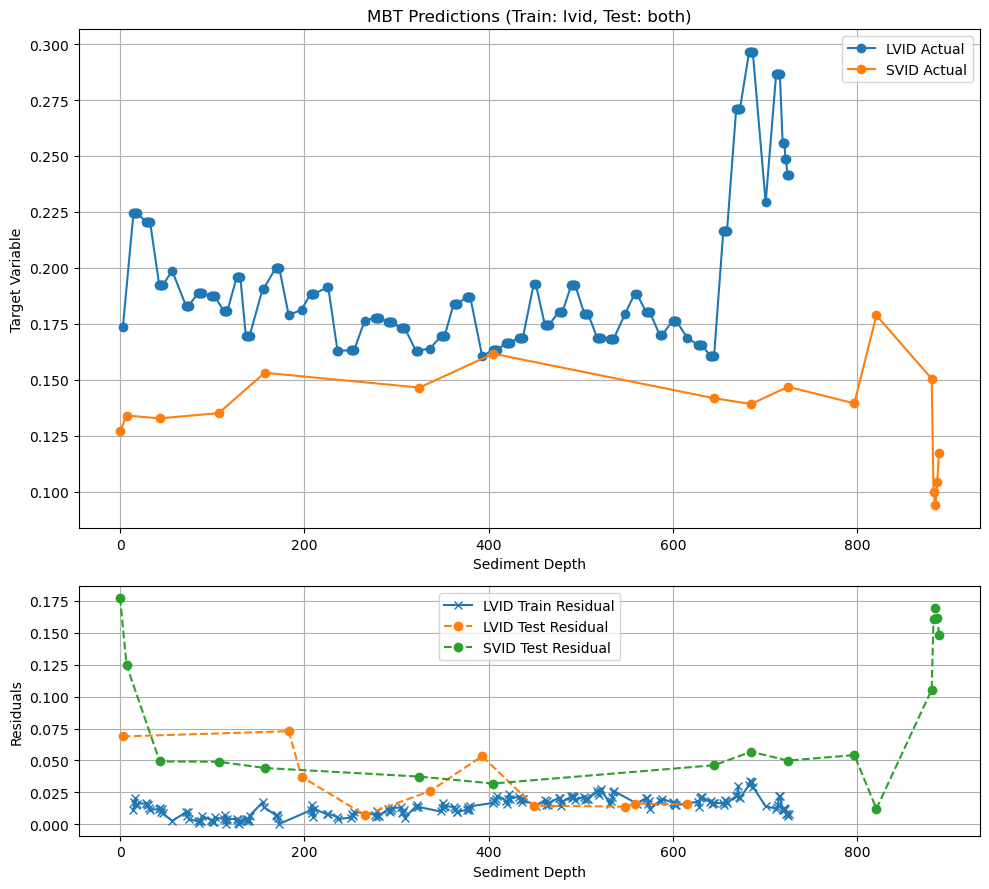

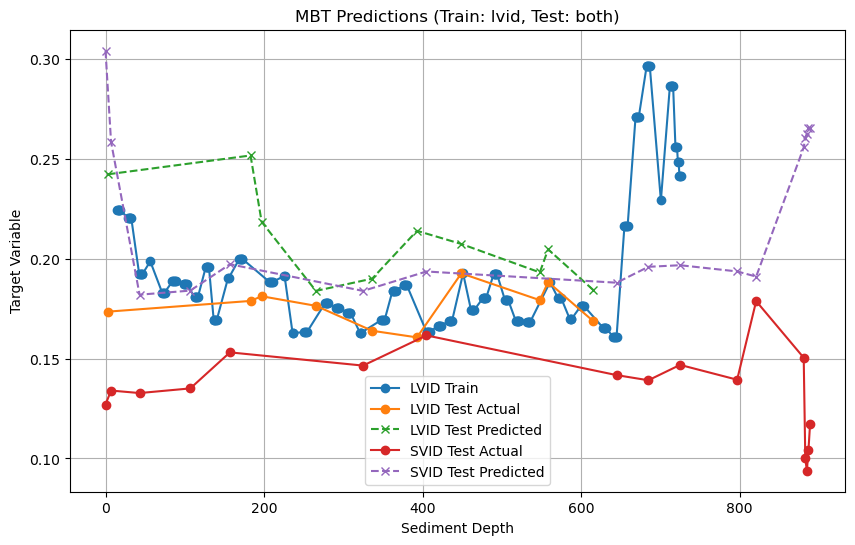

Running experiment for Target: MBT, Train: svid, Test: lvid


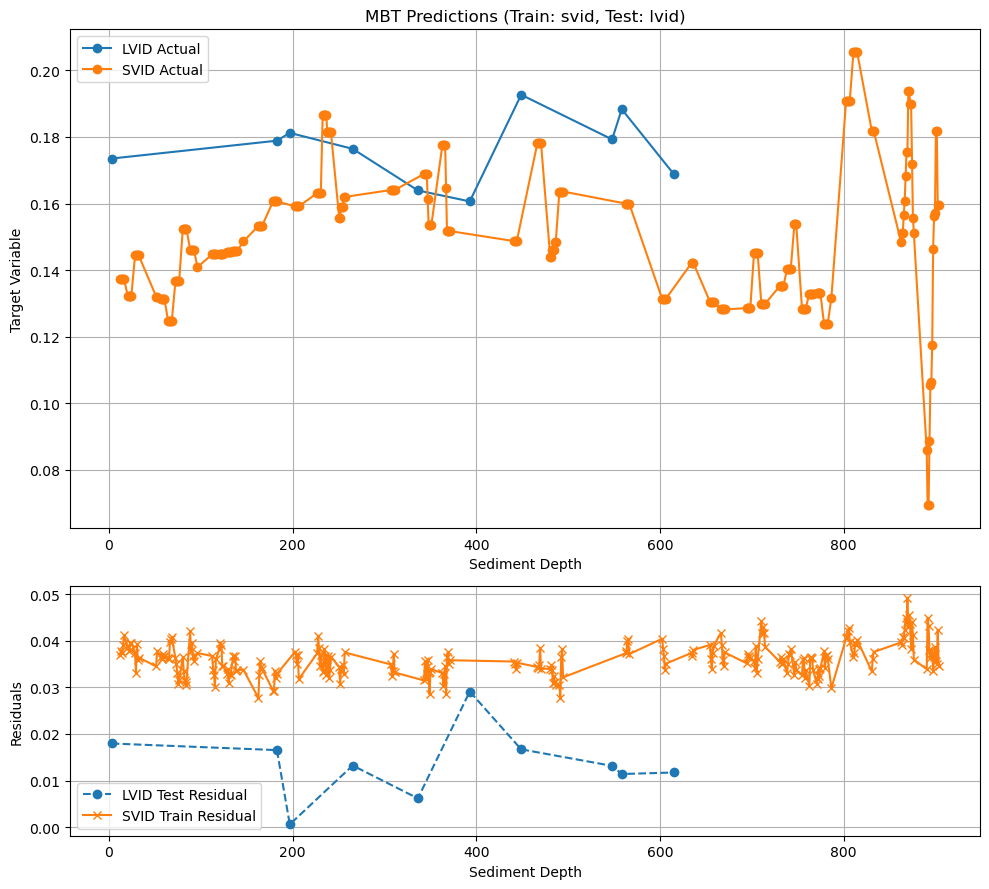

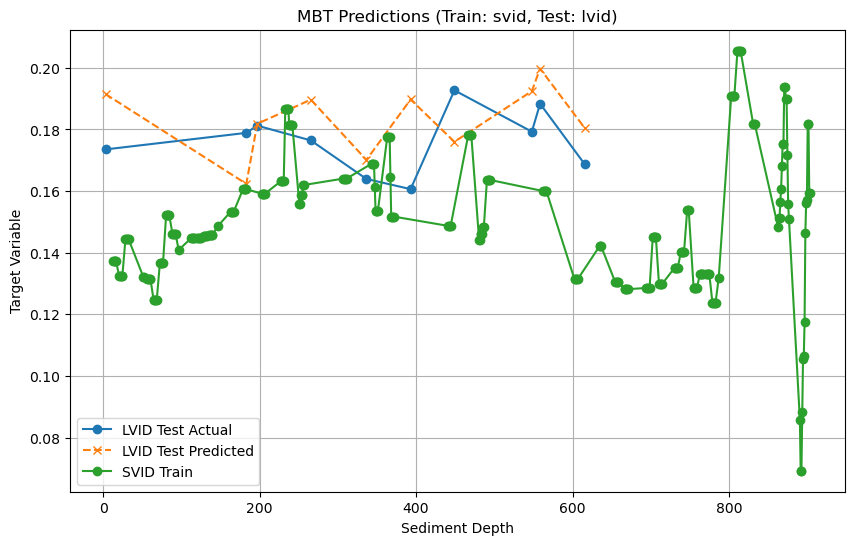

Running experiment for Target: MBT, Train: svid, Test: svid


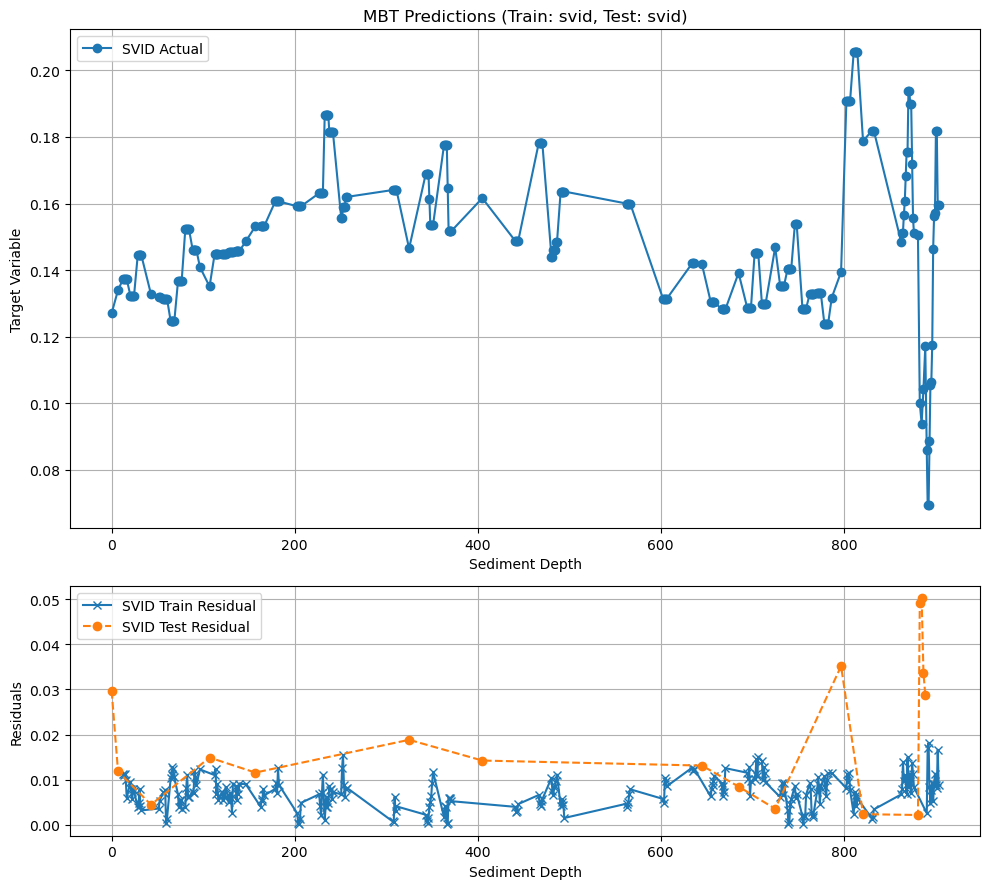

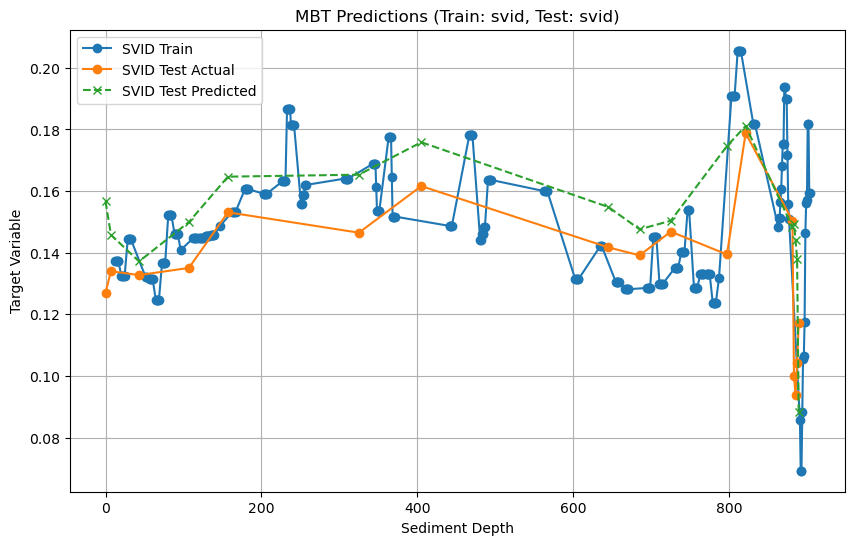

Running experiment for Target: MBT, Train: svid, Test: both


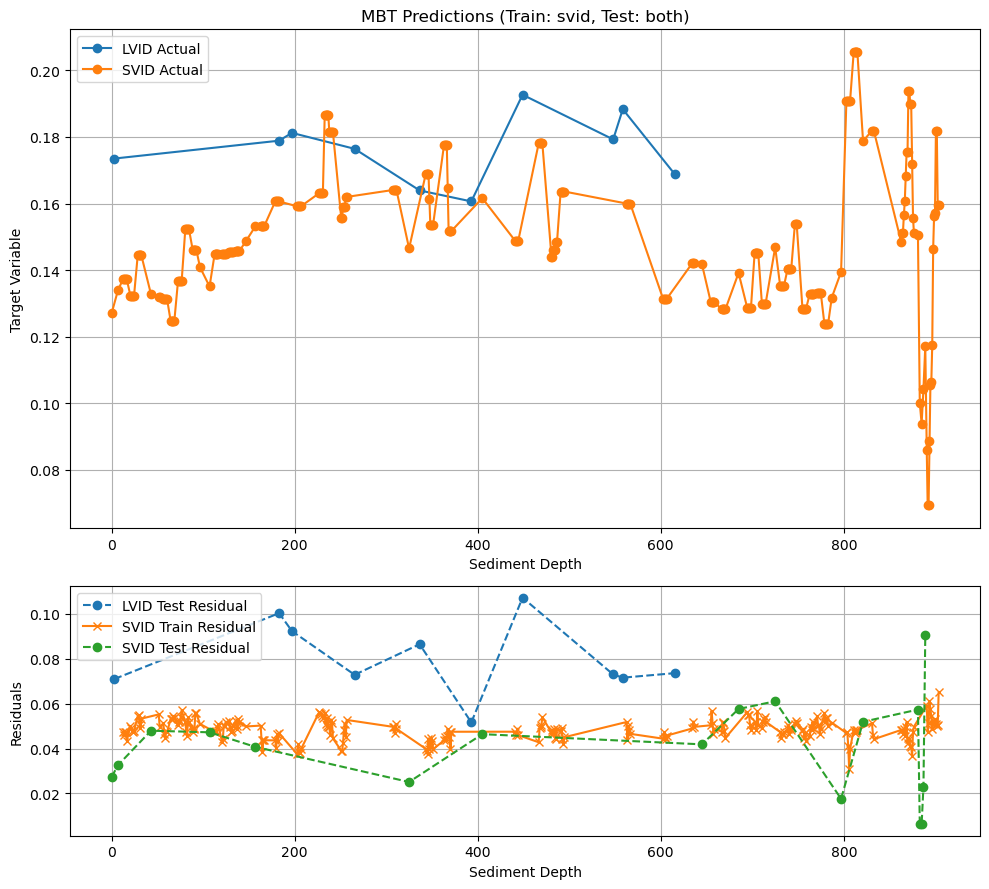

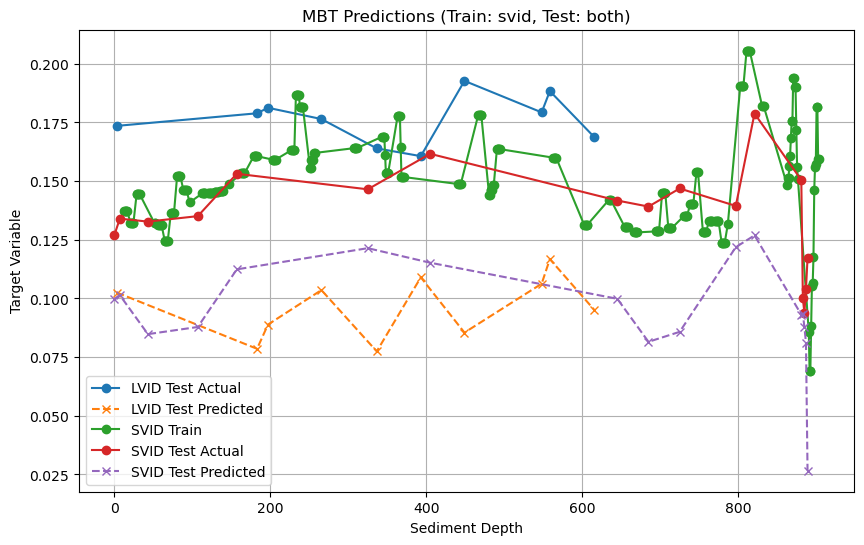

Running experiment for Target: MBT, Train: both, Test: lvid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


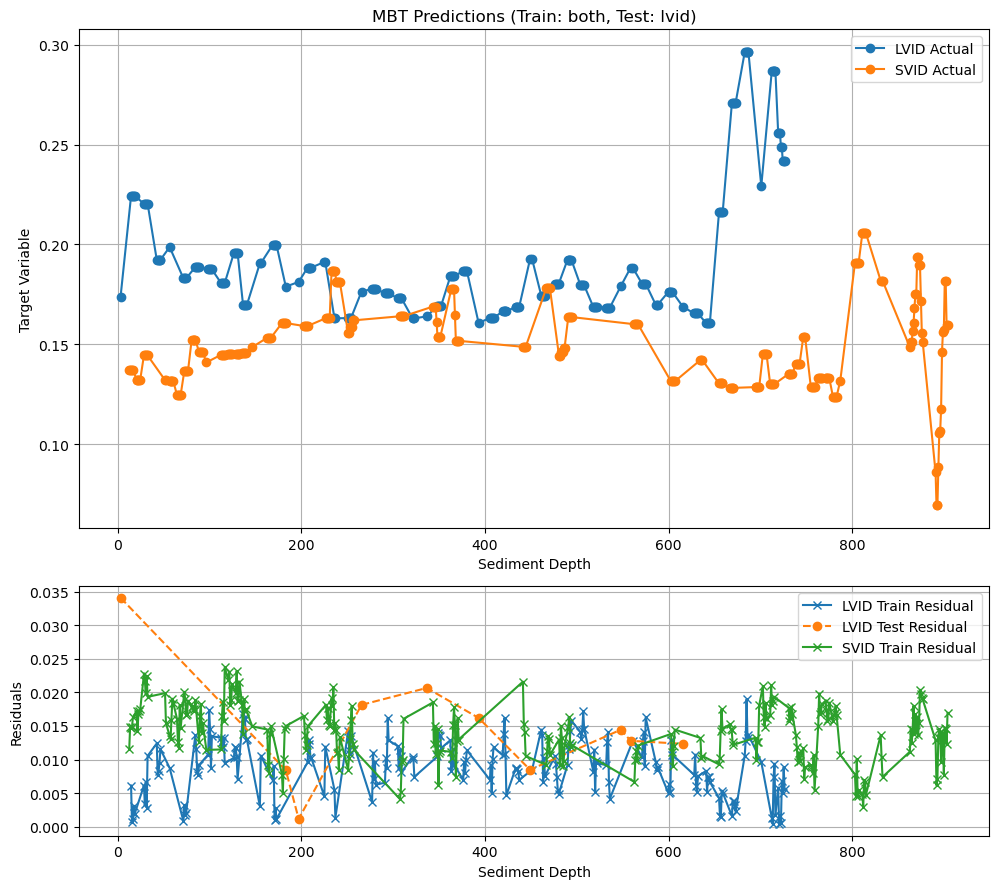

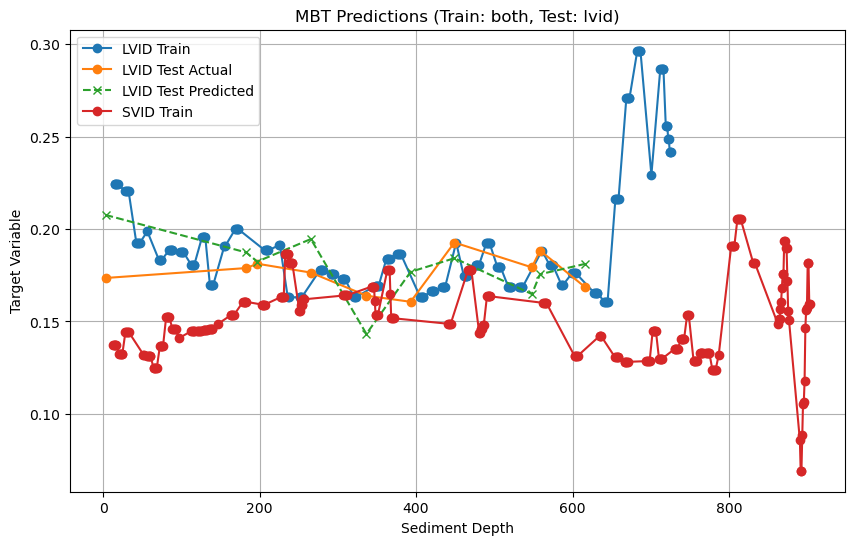

Running experiment for Target: MBT, Train: both, Test: svid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


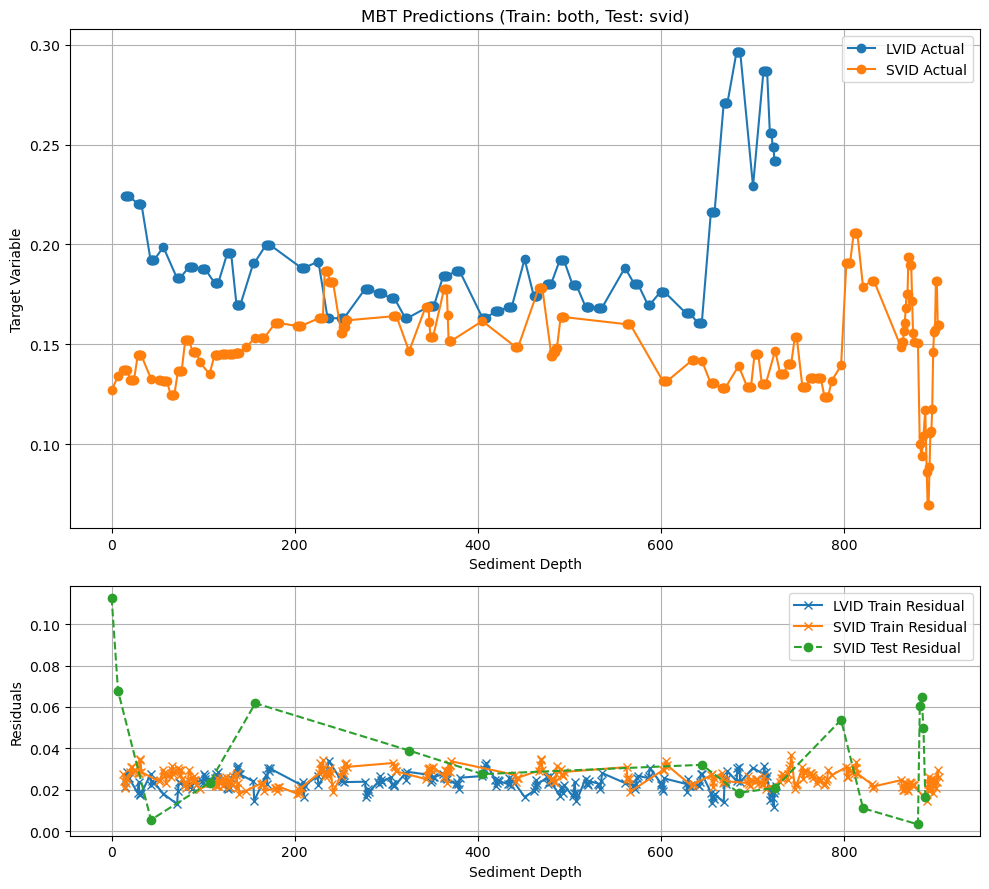

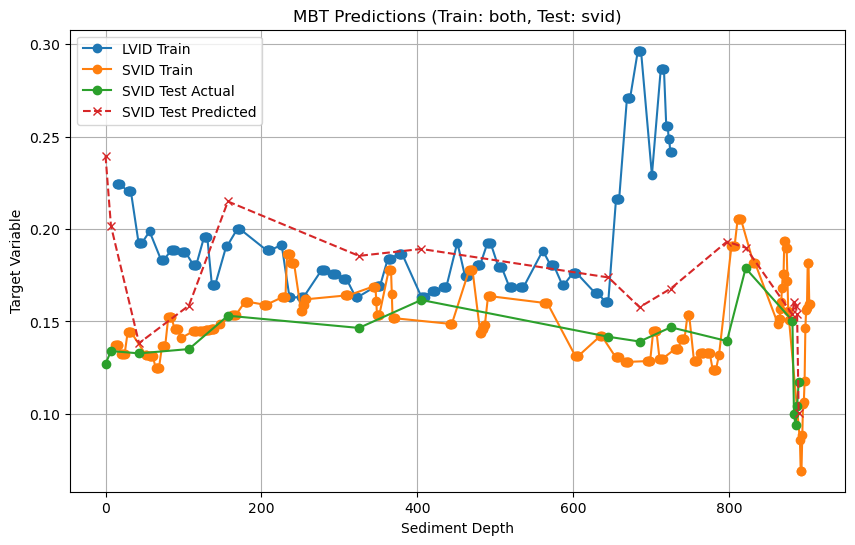

Running experiment for Target: MBT, Train: both, Test: both


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


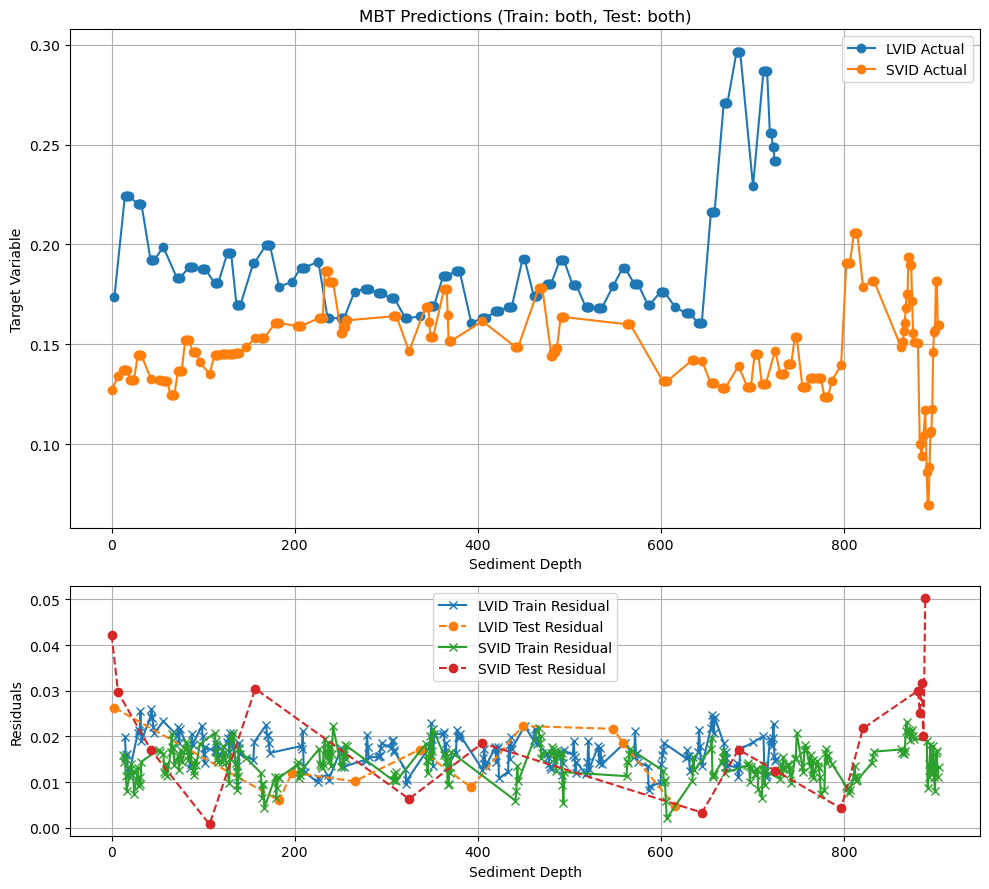

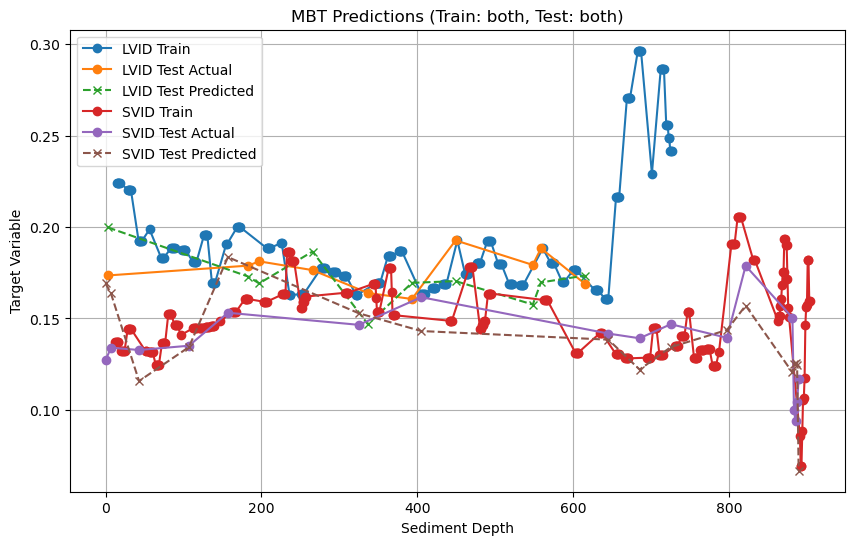

In [23]:
results = []

# Define the combinations
combinations = [
    ("lvid", "lvid"),
    ("lvid", "svid"),
    ("lvid", "both"),
    ("svid", "lvid"),
    ("svid", "svid"),
    ("svid", "both"),
    ("both", "lvid"),
    ("both", "svid"),
    ("both", "both")
]

## SVID: Train/Test
## LVID: Train Test
## Both (LVID + SVID): Train Test
targets = ['MBT']

# Load the pre-trained ViT model
pretrained_vit = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')

## Freeze params
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Create model w first three layers and create embedding
custom_model = CustomViTEmbeddingModel(pretrained_vit)

width = 5


for target in targets:
    for train_set, test_set in combinations:
        print(f"Running experiment for Target: {target}, Train: {train_set}, Test: {test_set}")
        
        cnn_model = RegressionCNN(embedding_dim=192)
        train_indices, train_depths, train_actuals, train_sources, train_predictions, test_indices, test_depths, test_actuals, test_predictions, test_sources = run_experiment(train_set, test_set, target, cnn_model, custom_model, sediment_width = width, num_epochs=100, lr=0.001)

        timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
        save_dir = f'data_exp_MA/{width}cm/plots/{target}'
        os.makedirs(save_dir, exist_ok=True)
        filename = f'{target}_{train_set}train{test_set}_test_{timestamp}.png'
        plot_title = f"{target} Predictions (Train: {train_set}, Test: {test_set})"
        save_path = os.path.join(save_dir, filename)
        rmse_save_path = f'data_exp_MA/{width}cm/rmse_data/{target}'
        os.makedirs(rmse_save_path, exist_ok=True)
        plot_results(train_depths, train_actuals, train_predictions, train_sources,  test_depths, test_actuals, test_predictions, test_sources, test_indices, plot_title, save_path,rmse_save_path)
        filename = f'OLD{target}_{train_set}train{test_set}_test_{timestamp}.png'
        save_path = os.path.join(save_dir, filename)
        old_plot_results(train_depths, train_actuals, train_predictions, train_sources, test_depths, test_actuals, test_predictions, test_sources, plot_title, save_path)

        # Calculate performance metrics
        rmse_value = np.sqrt(mean_squared_error(test_actuals, test_predictions))

        
        results.append({
            "Train Set": train_set,
            "Test Set": test_set,
            "Target": target,
            "RMSE": rmse_value,
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
save_dir = f'data_exp_MA/{width}cm/results'

# Saving the plot
# Ensure the target directory exists
os.makedirs(save_dir, exist_ok=True)
filename = f'experiment_results_{timestamp}.csv'
# Save the results to a CSV file
results_df.to_csv(os.path.join(save_dir, filename), index=False)



In [ ]:
results = []

# Define the combinations
combinations = [
    ("lvid", "lvid"),
    ("lvid", "svid"),
    ("lvid", "both"),
    ("svid", "lvid"),
    ("svid", "svid"),
    ("svid", "both"),
    ("both", "lvid"),
    ("both", "svid"),
    ("both", "both")
]

## SVID: Train/Test
## LVID: Train Test
## Both (LVID + SVID): Train Test
targets = ['MBT', '%TOC']

# Load the pre-trained ViT model
pretrained_vit = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')

## Freeze params
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Create model w first three layers and create embedding
custom_model = CustomViTEmbeddingModel(pretrained_vit)

width = 1


for target in targets:
    for train_set, test_set in combinations:
        print(f"Running experiment for Target: {target}, Train: {train_set}, Test: {test_set}")
        
        cnn_model = RegressionCNN(embedding_dim=192)
        train_indices, train_depths, train_actuals, train_sources, train_predictions, test_indices, test_depths, test_actuals, test_predictions, test_sources = run_experiment(train_set, test_set, target, cnn_model, custom_model, sediment_width = width, num_epochs=100, lr=0.001)

        timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
        save_dir = f'data_exp/{width}cm/plots'
        os.makedirs(save_dir, exist_ok=True)
        filename = f'{target}_{train_set}train{test_set}_test_{timestamp}.png'
        plot_title = f"{target} Predictions (Train: {train_set}, Test: {test_set})"
        save_path = os.path.join(save_dir, filename)
        rmse_save_path = f'data_exp/{width}cm/rmse_data/{target}'
        os.makedirs(rmse_save_path, exist_ok=True)
        plot_results(train_depths, train_actuals, train_predictions, train_sources,  test_depths, test_actuals, test_predictions, test_sources, test_indices, plot_title, save_path,rmse_save_path)
        filename = f'OLD{target}_{train_set}train{test_set}_test_{timestamp}.png'
        save_path = os.path.join(save_dir, filename)
        old_plot_results(train_depths, train_actuals, train_predictions, train_sources, test_depths, test_actuals, test_predictions, test_sources, plot_title, save_path)

        # Calculate performance metrics
        rmse_value = np.sqrt(mean_squared_error(test_actuals, test_predictions))

        
        results.append({
            "Train Set": train_set,
            "Test Set": test_set,
            "Target": target,
            "RMSE": rmse_value,
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
save_dir = f'data_exp/{width}cm/results'

# Saving the plot
# Ensure the target directory exists
os.makedirs(save_dir, exist_ok=True)
filename = f'experiment_results_{timestamp}.csv'
# Save the results to a CSV file
results_df.to_csv(os.path.join(save_dir, filename), index=False)
